# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 16  
data_points_exp = 30000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([30000, 16]), psi_samples_exp_tensor shape torch.Size([30000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 7730.52294921875
iteration 0 loss 2690.47265625


iteration 500 loss 87.94657897949219


iteration 1000 loss 45.71549987792969


iteration 1500 loss 3.596956729888916


iteration 2000 loss 2.152827262878418


iteration 2500 loss 1.5971037149429321


iteration 3000 loss 1.2262400388717651


iteration 3500 loss 0.969706654548645


iteration 4000 loss 0.8715771436691284


iteration 4500 loss 0.7347822785377502


iteration 5000 loss 0.6316255331039429


iteration 5500 loss 0.7079885005950928


iteration 6000 loss 0.5735320448875427


iteration 6500 loss 0.5077577233314514


iteration 7000 loss 0.4560154378414154


iteration 7500 loss 0.40945422649383545


iteration 8000 loss 0.3924421966075897


iteration 8500 loss 0.3554827570915222


iteration 9000 loss 0.37635260820388794


iteration 9500 loss 0.33391299843788147


iteration 10000 loss 0.30595818161964417


iteration 10500 loss 0.34785667061805725


iteration 11000 loss 0.26979994773864746


iteration 11500 loss 0.28433287143707275


iteration 12000 loss 0.2523188591003418


iteration 12500 loss 0.23384878039360046


iteration 13000 loss 0.2449263334274292


iteration 13500 loss 0.21946834027767181


iteration 14000 loss 0.20461779832839966


iteration 14500 loss 0.21057945489883423


iteration 15000 loss 0.19319377839565277


iteration 15500 loss 0.1812295764684677


iteration 16000 loss 0.18006770312786102


iteration 16500 loss 0.16866521537303925


iteration 17000 loss 0.17461250722408295


iteration 17500 loss 0.16101109981536865


iteration 18000 loss 0.15190930664539337


iteration 18500 loss 0.15233372151851654


iteration 19000 loss 0.14299805462360382


iteration 19500 loss 0.14305242896080017


iteration 20000 loss 0.1340993195772171


iteration 20500 loss 0.1403825879096985


iteration 21000 loss 0.12944266200065613


iteration 21500 loss 0.12264392524957657


iteration 22000 loss 0.12113509327173233


iteration 22500 loss 0.12299367040395737


iteration 23000 loss 0.11344848573207855


iteration 23500 loss 0.1142900139093399


iteration 24000 loss 0.10666709393262863


iteration 24500 loss 0.10509997606277466


iteration 25000 loss 0.10638698190450668


iteration 25500 loss 0.09858154505491257


iteration 26000 loss 0.09837505966424942


iteration 26500 loss 0.09388572722673416


iteration 27000 loss 0.09244593232870102


iteration 27500 loss 0.09590325504541397


iteration 28000 loss 0.0880165547132492


iteration 28500 loss 0.09057687222957611


iteration 29000 loss 0.0840705931186676


iteration 29500 loss 0.086273193359375


iteration 30000 loss 0.08047716319561005


iteration 30500 loss 0.08206631243228912


iteration 31000 loss 0.07695086300373077


iteration 31500 loss 0.07773864269256592


iteration 32000 loss 0.07345812022686005


iteration 32500 loss 0.07335208356380463


iteration 33000 loss 0.07359420508146286


iteration 33500 loss 0.06919535994529724


iteration 34000 loss 0.06899739056825638


iteration 34500 loss 0.07109791040420532


iteration 35000 loss 0.06613340228796005


iteration 35500 loss 0.06640094518661499


iteration 36000 loss 0.12530294060707092


iteration 36500 loss 0.06313568353652954


iteration 37000 loss 0.06398390233516693


iteration 37500 loss 0.060190144926309586


iteration 38000 loss 0.0602802038192749


iteration 38500 loss 0.059686366468667984


iteration 39000 loss 0.059727445244789124


iteration 39500 loss 0.329184889793396


iteration 40000 loss 0.055660467594861984


iteration 40500 loss 0.05532039329409599


iteration 41000 loss 0.055369582027196884


iteration 41500 loss 0.05501088872551918


iteration 42000 loss 0.055388085544109344


iteration 42500 loss 0.2685515880584717


iteration 43000 loss 0.05079357698559761


iteration 43500 loss 0.050456251949071884


iteration 44000 loss 0.050163403153419495


iteration 44500 loss 0.049888819456100464


iteration 45000 loss 0.04880299046635628


iteration 45500 loss 0.048266466706991196


iteration 46000 loss 0.04726260155439377


iteration 46500 loss 0.04686642438173294


iteration 47000 loss 0.15046441555023193


iteration 47500 loss 0.04930708184838295


iteration 48000 loss 0.04600941762328148


iteration 48500 loss 0.05891924723982811


iteration 49000 loss 1.7281116247177124


iteration 49500 loss 3.2178761959075928


iteration 50000 loss 0.04639310762286186


iteration 50500 loss 0.044379208236932755


iteration 51000 loss 0.04479146748781204


iteration 51500 loss 0.08687524497509003


iteration 52000 loss 0.041386328637599945


iteration 52500 loss 0.04053328558802605


iteration 53000 loss 0.040020979940891266


iteration 53500 loss 0.03949011117219925


iteration 54000 loss 0.03907139599323273


iteration 54500 loss 0.0385601632297039


iteration 55000 loss 0.038018204271793365


iteration 55500 loss 0.03752242028713226


iteration 56000 loss 0.03709884360432625


iteration 56500 loss 0.036769505590200424


iteration 57000 loss 0.036290038377046585


iteration 57500 loss 0.4267682433128357


iteration 58000 loss 0.04256460815668106


iteration 58500 loss 0.0365566648542881


iteration 59000 loss 0.035691242665052414


iteration 59500 loss 0.03703321889042854


iteration 60000 loss 0.034886687994003296


iteration 60500 loss 0.03430052101612091


iteration 61000 loss 0.03375569358468056


iteration 61500 loss 0.38076281547546387


iteration 62000 loss 0.03439943864941597


iteration 62500 loss 0.033489953726530075


iteration 63000 loss 0.032773371785879135


iteration 63500 loss 0.03232063725590706


iteration 64000 loss 0.09706782549619675


iteration 64500 loss 0.03313317149877548


iteration 65000 loss 0.03182080760598183


iteration 65500 loss 0.03199978545308113


iteration 66000 loss 0.03603336587548256


iteration 66500 loss 0.031187858432531357


iteration 67000 loss 0.030547188594937325


iteration 67500 loss 2.173680067062378


iteration 68000 loss 0.031166652217507362


iteration 68500 loss 0.07225827127695084


iteration 69000 loss 0.02963237836956978


iteration 69500 loss 0.031102744862437248


iteration 70000 loss 0.03240155428647995


iteration 70500 loss 0.029944535344839096


iteration 71000 loss 0.02913740836083889


iteration 71500 loss 0.02851448766887188


iteration 72000 loss 0.4689811170101166


iteration 72500 loss 0.1024136021733284


iteration 73000 loss 0.02784552052617073


iteration 73500 loss 0.02821754664182663


iteration 74000 loss 0.027416780591011047


iteration 74500 loss 0.028144370764493942


iteration 75000 loss 0.027264904230833054


iteration 75500 loss 0.03128727152943611


iteration 76000 loss 0.026900894939899445


iteration 76500 loss 0.030864328145980835


iteration 77000 loss 0.026772696524858475


iteration 77500 loss 0.13009077310562134


iteration 78000 loss 0.02628319524228573


iteration 78500 loss 0.026995575055480003


iteration 79000 loss 0.025835050269961357


iteration 79500 loss 0.0262148454785347


iteration 80000 loss 0.025438223034143448


iteration 80500 loss 0.02585556171834469


iteration 81000 loss 0.027229418978095055


iteration 81500 loss 0.02515539526939392


iteration 82000 loss 0.06683400273323059


iteration 82500 loss 0.024750089272856712


iteration 83000 loss 0.024870354682207108


iteration 83500 loss 0.02498113363981247


iteration 84000 loss 0.025395385921001434


iteration 84500 loss 0.05699863284826279


iteration 85000 loss 0.024198584258556366


iteration 85500 loss 0.024340014904737473


iteration 86000 loss 0.024030357599258423


iteration 86500 loss 0.023897327482700348


iteration 87000 loss 2.4603803157806396


iteration 87500 loss 0.02553935907781124


iteration 88000 loss 0.0384586900472641


iteration 88500 loss 0.027253124862909317


iteration 89000 loss 0.023843852803111076


iteration 89500 loss 0.12542088329792023


iteration 90000 loss 0.040087927132844925


iteration 90500 loss 0.54889976978302


iteration 91000 loss 0.04166369512677193


iteration 91500 loss 0.038326092064380646


iteration 92000 loss 0.20143450796604156


iteration 92500 loss 0.0626770481467247


iteration 93000 loss 0.024001382291316986


iteration 93500 loss 0.048274554312229156


iteration 94000 loss 0.5393141508102417


iteration 94500 loss 0.14124196767807007


iteration 95000 loss 0.11099748313426971


iteration 95500 loss 0.03925580158829689


iteration 96000 loss 0.27293360233306885


iteration 96500 loss 0.05200057104229927


iteration 97000 loss 0.11810136586427689


iteration 97500 loss 0.03576875105500221


iteration 98000 loss 0.18166093528270721


iteration 98500 loss 0.048674553632736206


iteration 99000 loss 0.02198101580142975


iteration 99500 loss 0.06803740561008453


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.023687466979026794


iteration 100500 loss 0.020718805491924286


iteration 101000 loss 0.020505404099822044


iteration 101500 loss 0.02029220387339592


iteration 102000 loss 0.020072782412171364


iteration 102500 loss 0.01984432525932789


iteration 103000 loss 0.019605552777647972


iteration 103500 loss 0.019355591386556625


iteration 104000 loss 0.01909305714070797


iteration 104500 loss 0.01881585642695427


iteration 105000 loss 0.018556566908955574


iteration 105500 loss 0.01834099553525448


iteration 106000 loss 0.018137464299798012


iteration 106500 loss 0.01796812377870083


iteration 107000 loss 0.017806075513362885


iteration 107500 loss 0.01771821454167366


iteration 108000 loss 0.017512403428554535


iteration 108500 loss 0.01737414486706257


iteration 109000 loss 0.030960213392972946


iteration 109500 loss 0.017113786190748215


iteration 110000 loss 0.016987644135951996


iteration 110500 loss 0.01686829701066017


iteration 111000 loss 0.016762735322117805


iteration 111500 loss 0.016651451587677002


iteration 112000 loss 0.01654660515487194


iteration 112500 loss 0.016444241628050804


iteration 113000 loss 0.01635538786649704


iteration 113500 loss 0.016246233135461807


iteration 114000 loss 0.016150491312146187


iteration 114500 loss 0.016053015366196632


iteration 115000 loss 0.01596141792833805


iteration 115500 loss 0.015874670818448067


iteration 116000 loss 0.015785561874508858


iteration 116500 loss 0.01569809764623642


iteration 117000 loss 0.015605878084897995


iteration 117500 loss 0.015529935248196125


iteration 118000 loss 0.015438335947692394


iteration 118500 loss 0.015374590642750263


iteration 119000 loss 0.015295946970582008


iteration 119500 loss 0.015217414125800133


iteration 120000 loss 0.015137024223804474


iteration 120500 loss 0.015057808719575405


iteration 121000 loss 0.014978982508182526


iteration 121500 loss 0.014899774454534054


iteration 122000 loss 0.014824888668954372


iteration 122500 loss 0.014753991737961769


iteration 123000 loss 0.014680206775665283


iteration 123500 loss 0.014611788094043732


iteration 124000 loss 0.015271197073161602


iteration 124500 loss 0.014469153247773647


iteration 125000 loss 0.014423002488911152


iteration 125500 loss 0.014333701692521572


iteration 126000 loss 0.014264781028032303


iteration 126500 loss 0.014201867394149303


iteration 127000 loss 0.014134594239294529


iteration 127500 loss 0.014070047065615654


iteration 128000 loss 0.014007877558469772


iteration 128500 loss 0.013940686360001564


iteration 129000 loss 0.013880790211260319


iteration 129500 loss 0.013816013932228088


iteration 130000 loss 0.013753137551248074


iteration 130500 loss 0.013689172454178333


iteration 131000 loss 0.013661213219165802


iteration 131500 loss 0.013707472011446953


iteration 132000 loss 0.01350921019911766


iteration 132500 loss 0.013449995778501034


iteration 133000 loss 0.013394112698733807


iteration 133500 loss 0.01340970303863287


iteration 134000 loss 0.013281538151204586


iteration 134500 loss 0.013225785456597805


iteration 135000 loss 0.013172217644751072


iteration 135500 loss 0.013219853863120079


iteration 136000 loss 0.013061855919659138


iteration 136500 loss 0.013006667606532574


iteration 137000 loss 0.03892695531249046


iteration 137500 loss 0.01290261559188366


iteration 138000 loss 0.012849808670580387


iteration 138500 loss 0.012795108370482922


iteration 139000 loss 0.012748384848237038


iteration 139500 loss 0.012698336504399776


iteration 140000 loss 0.012644224800169468


iteration 140500 loss 0.01259901374578476


iteration 141000 loss 0.012548938393592834


iteration 141500 loss 0.012498268857598305


iteration 142000 loss 0.012446838431060314


iteration 142500 loss 0.012402288615703583


iteration 143000 loss 0.012357293628156185


iteration 143500 loss 0.012305574491620064


iteration 144000 loss 0.012256086803972721


iteration 144500 loss 0.01220728736370802


iteration 145000 loss 0.012164861895143986


iteration 145500 loss 0.012117431499063969


iteration 146000 loss 0.01207317691296339


iteration 146500 loss 0.01202978752553463


iteration 147000 loss 0.011988606303930283


iteration 147500 loss 0.05712904408574104


iteration 148000 loss 0.011894099414348602


iteration 148500 loss 0.011849777773022652


iteration 149000 loss 0.01180773414671421


iteration 149500 loss 0.01176057755947113


iteration 150000 loss 0.011726082302629948


iteration 150500 loss 0.011774330399930477


iteration 151000 loss 0.011641085147857666


iteration 151500 loss 0.01159736793488264


iteration 152000 loss 0.01155686005949974


iteration 152500 loss 0.011515039019286633


iteration 153000 loss 0.011472350917756557


iteration 153500 loss 0.011432493105530739


iteration 154000 loss 0.011390574276447296


iteration 154500 loss 0.011352027766406536


iteration 155000 loss 0.011314413510262966


iteration 155500 loss 0.011272145435214043


iteration 156000 loss 0.011237343773245811


iteration 156500 loss 0.011204974725842476


iteration 157000 loss 0.01116268802434206


iteration 157500 loss 0.011127501726150513


iteration 158000 loss 0.011105097830295563


iteration 158500 loss 0.011055530980229378


iteration 159000 loss 0.011016974225640297


iteration 159500 loss 0.010983671061694622


iteration 160000 loss 0.01109424326568842


iteration 160500 loss 0.010917515493929386


iteration 161000 loss 0.011153641156852245


iteration 161500 loss 0.010837341658771038


iteration 162000 loss 0.010807359591126442


iteration 162500 loss 0.010903328657150269


iteration 163000 loss 0.010732428170740604


iteration 163500 loss 0.010700445622205734


iteration 164000 loss 0.010661324486136436


iteration 164500 loss 0.010630764067173004


iteration 165000 loss 0.022473569959402084


iteration 165500 loss 0.010562717914581299


iteration 166000 loss 0.010529923252761364


iteration 166500 loss 0.010496244765818119


iteration 167000 loss 0.010462101548910141


iteration 167500 loss 0.010432659648358822


iteration 168000 loss 0.010398630984127522


iteration 168500 loss 0.01036753412336111


iteration 169000 loss 0.010337801650166512


iteration 169500 loss 0.010522437281906605


iteration 170000 loss 0.010272812098264694


iteration 170500 loss 0.010241091251373291


iteration 171000 loss 0.010208447463810444


iteration 171500 loss 0.010310659185051918


iteration 172000 loss 0.01014701183885336


iteration 172500 loss 0.01011673640459776


iteration 173000 loss 0.010084169916808605


iteration 173500 loss 0.010051997378468513


iteration 174000 loss 0.010021745227277279


iteration 174500 loss 0.009990808553993702


iteration 175000 loss 0.011744030751287937


iteration 175500 loss 0.009931041859090328


iteration 176000 loss 0.009899440221488476


iteration 176500 loss 0.009870793670415878


iteration 177000 loss 0.00984291173517704


iteration 177500 loss 0.009812425822019577


iteration 178000 loss 0.009783303365111351


iteration 178500 loss 0.00975677091628313


iteration 179000 loss 0.011487013660371304


iteration 179500 loss 0.009700006805360317


iteration 180000 loss 0.009673120453953743


iteration 180500 loss 0.00967120099812746


iteration 181000 loss 0.009967124089598656


iteration 181500 loss 0.009586209431290627


iteration 182000 loss 0.009575797244906425


iteration 182500 loss 0.009547107852995396


iteration 183000 loss 0.00950421392917633


iteration 183500 loss 0.009476973675191402


iteration 184000 loss 0.00945010781288147


iteration 184500 loss 0.009424170479178429


iteration 185000 loss 0.00939749926328659


iteration 185500 loss 0.009369558654725552


iteration 186000 loss 0.009714130312204361


iteration 186500 loss 0.011816125363111496


iteration 187000 loss 0.00929282233119011


iteration 187500 loss 0.009266827255487442


iteration 188000 loss 0.009241585619747639


iteration 188500 loss 0.009219006635248661


iteration 189000 loss 0.009194282814860344


iteration 189500 loss 0.009167763404548168


iteration 190000 loss 0.009186876937747002


iteration 190500 loss 0.009120243601500988


iteration 191000 loss 0.009096412919461727


iteration 191500 loss 0.00907169934362173


iteration 192000 loss 0.009055259637534618


iteration 192500 loss 0.009022731333971024


iteration 193000 loss 0.008998768404126167


iteration 193500 loss 0.008974875323474407


iteration 194000 loss 0.00894980039447546


iteration 194500 loss 0.009345331229269505


iteration 195000 loss 0.008904485031962395


iteration 195500 loss 0.008878176100552082


iteration 196000 loss 0.008857625536620617


iteration 196500 loss 0.01063587050884962


iteration 197000 loss 0.011482594534754753


iteration 197500 loss 0.02115442417562008


iteration 198000 loss 0.008763437159359455


iteration 198500 loss 0.008740918710827827


iteration 199000 loss 0.008719251491129398


iteration 199500 loss 0.00869671069085598


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.008680594153702259


iteration 200500 loss 0.008675236254930496


iteration 201000 loss 0.008670982904732227


iteration 201500 loss 0.008666363544762135


iteration 202000 loss 0.008661157451570034


iteration 202500 loss 0.008654982782900333


iteration 203000 loss 0.008647363632917404


iteration 203500 loss 0.008637741208076477


iteration 204000 loss 0.008625539019703865


iteration 204500 loss 0.008609968237578869


iteration 205000 loss 0.008590089157223701


iteration 205500 loss 0.008564864285290241


iteration 206000 loss 0.008549341931939125


iteration 206500 loss 0.008532015606760979


iteration 207000 loss 0.008510066196322441


iteration 207500 loss 0.008488882333040237


iteration 208000 loss 0.00847253855317831


iteration 208500 loss 0.008451666682958603


iteration 209000 loss 0.008431455120444298


iteration 209500 loss 0.008413930423557758


iteration 210000 loss 0.008394044823944569


iteration 210500 loss 0.008373018354177475


iteration 211000 loss 0.008356726728379726


iteration 211500 loss 0.008335914462804794


iteration 212000 loss 0.008317072875797749


iteration 212500 loss 0.008298395201563835


iteration 213000 loss 0.008276734501123428


iteration 213500 loss 0.00826039258390665


iteration 214000 loss 0.008239898830652237


iteration 214500 loss 0.008218172937631607


iteration 215000 loss 0.008205298334360123


iteration 215500 loss 0.0081889433786273


iteration 216000 loss 0.008168221451342106


iteration 216500 loss 0.008150937035679817


iteration 217000 loss 0.008132069371640682


iteration 217500 loss 0.008111800067126751


iteration 218000 loss 0.00809693057090044


iteration 218500 loss 0.008078615181148052


iteration 219000 loss 0.008058978244662285


iteration 219500 loss 0.008043983019888401


iteration 220000 loss 0.008025088347494602


iteration 220500 loss 0.008007564581930637


iteration 221000 loss 0.00799062754958868


iteration 221500 loss 0.007970831356942654


iteration 222000 loss 0.00795520655810833


iteration 222500 loss 0.007939083501696587


iteration 223000 loss 0.007917976006865501


iteration 223500 loss 0.007905344478785992


iteration 224000 loss 0.007889555767178535


iteration 224500 loss 0.007875803858041763


iteration 225000 loss 0.007854852825403214


iteration 225500 loss 0.007837342098355293


iteration 226000 loss 0.007819483987987041


iteration 226500 loss 0.007804670371115208


iteration 227000 loss 0.00778582040220499


iteration 227500 loss 0.00777050293982029


iteration 228000 loss 0.0077565633691847324


iteration 228500 loss 0.0077387308701872826


iteration 229000 loss 0.007722834125161171


iteration 229500 loss 0.007707920856773853


iteration 230000 loss 0.0076892985962331295


iteration 230500 loss 0.007674519903957844


iteration 231000 loss 0.007660042028874159


iteration 231500 loss 0.0076448870822787285


iteration 232000 loss 0.007627503480762243


iteration 232500 loss 0.007612555753439665


iteration 233000 loss 0.007600998971611261


iteration 233500 loss 0.007580653764307499


iteration 234000 loss 0.007563439663499594


iteration 234500 loss 0.007547385059297085


iteration 235000 loss 0.007534532342106104


iteration 235500 loss 0.0075181229040026665


iteration 236000 loss 0.007502792403101921


iteration 236500 loss 0.007487949915230274


iteration 237000 loss 0.007469130679965019


iteration 237500 loss 0.007457556203007698


iteration 238000 loss 0.007443895097821951


iteration 238500 loss 0.007433299440890551


iteration 239000 loss 0.007411858532577753


iteration 239500 loss 0.00753424596041441


iteration 240000 loss 0.00738254189491272


iteration 240500 loss 0.007369120139628649


iteration 241000 loss 0.007352066226303577


iteration 241500 loss 0.00733921118080616


iteration 242000 loss 0.007325733546167612


iteration 242500 loss 0.00730868661776185


iteration 243000 loss 0.007296572905033827


iteration 243500 loss 0.007282761856913567


iteration 244000 loss 0.0072667659260332584


iteration 244500 loss 0.007253664080053568


iteration 245000 loss 0.007237561047077179


iteration 245500 loss 0.007224577944725752


iteration 246000 loss 0.007211123127490282


iteration 246500 loss 0.007194916717708111


iteration 247000 loss 0.007182576227933168


iteration 247500 loss 0.007169946562498808


iteration 248000 loss 0.007153868209570646


iteration 248500 loss 0.007141886278986931


iteration 249000 loss 0.007128183264285326


iteration 249500 loss 0.0071132006123661995


iteration 250000 loss 0.007100954651832581


iteration 250500 loss 0.007085462566465139


iteration 251000 loss 0.0070728762075304985


iteration 251500 loss 0.007060761097818613


iteration 252000 loss 0.007045426871627569


iteration 252500 loss 0.007033216301351786


iteration 253000 loss 0.007020199671387672


iteration 253500 loss 0.00700376508757472


iteration 254000 loss 0.006993317976593971


iteration 254500 loss 0.006982448045164347


iteration 255000 loss 0.006968524772673845


iteration 255500 loss 0.006954800337553024


iteration 256000 loss 0.0069437166675925255


iteration 256500 loss 0.006929589901119471


iteration 257000 loss 0.00691703986376524


iteration 257500 loss 0.006903982721269131


iteration 258000 loss 0.006889213342219591


iteration 258500 loss 0.006878919433802366


iteration 259000 loss 0.006868116557598114


iteration 259500 loss 0.006852699909359217


iteration 260000 loss 0.006840276997536421


iteration 260500 loss 0.0068264673464000225


iteration 261000 loss 0.006815219298005104


iteration 261500 loss 0.0068010324612259865


iteration 262000 loss 0.006788995582610369


iteration 262500 loss 0.006779483053833246


iteration 263000 loss 0.006767331622540951


iteration 263500 loss 0.006754057016223669


iteration 264000 loss 0.00674204807728529


iteration 264500 loss 0.006728712003678083


iteration 265000 loss 0.006717884447425604


iteration 265500 loss 0.006705143488943577


iteration 266000 loss 0.006693102419376373


iteration 266500 loss 0.006684437859803438


iteration 267000 loss 0.006668348331004381


iteration 267500 loss 0.0066573782823979855


iteration 268000 loss 0.006643455475568771


iteration 268500 loss 0.006632939912378788


iteration 269000 loss 0.006622506305575371


iteration 269500 loss 0.006610450334846973


iteration 270000 loss 0.006598588079214096


iteration 270500 loss 0.0065875062718987465


iteration 271000 loss 0.006574578117579222


iteration 271500 loss 0.006564284209161997


iteration 272000 loss 0.006551354192197323


iteration 272500 loss 0.006540343631058931


iteration 273000 loss 0.006531325168907642


iteration 273500 loss 0.006520490627735853


iteration 274000 loss 0.006507872603833675


iteration 274500 loss 0.006495136301964521


iteration 275000 loss 0.0064846244640648365


iteration 275500 loss 0.006471998058259487


iteration 276000 loss 0.006460858508944511


iteration 276500 loss 0.006451733410358429


iteration 277000 loss 0.006440177094191313


iteration 277500 loss 0.006428942549973726


iteration 278000 loss 0.006418170407414436


iteration 278500 loss 0.006405971944332123


iteration 279000 loss 0.006396820303052664


iteration 279500 loss 0.00638629961758852


iteration 280000 loss 0.006374043878167868


iteration 280500 loss 0.006364219356328249


iteration 281000 loss 0.006352712865918875


iteration 281500 loss 0.006342566106468439


iteration 282000 loss 0.006332681979984045


iteration 282500 loss 0.007015405222773552


iteration 283000 loss 0.006311020813882351


iteration 283500 loss 0.006300376262515783


iteration 284000 loss 0.006288721691817045


iteration 284500 loss 0.006279973313212395


iteration 285000 loss 0.006269154138863087


iteration 285500 loss 0.006258141249418259


iteration 286000 loss 0.0062490422278642654


iteration 286500 loss 0.006245274096727371


iteration 287000 loss 0.006227834150195122


iteration 287500 loss 0.006219261791557074


iteration 288000 loss 0.006208435166627169


iteration 288500 loss 0.006198211573064327


iteration 289000 loss 0.0061885397881269455


iteration 289500 loss 0.006181173492223024


iteration 290000 loss 0.006168629974126816


iteration 290500 loss 0.0061593311838805676


iteration 291000 loss 0.006498279049992561


iteration 291500 loss 0.00613894360139966


iteration 292000 loss 0.006127899046987295


iteration 292500 loss 0.006118584889918566


iteration 293000 loss 0.006108306813985109


iteration 293500 loss 0.006097561679780483


iteration 294000 loss 0.006089729256927967


iteration 294500 loss 0.006079832091927528


iteration 295000 loss 0.006068778689950705


iteration 295500 loss 0.006060995161533356


iteration 296000 loss 0.00605140021070838


iteration 296500 loss 0.006040813401341438


iteration 297000 loss 0.00603253161534667


iteration 297500 loss 0.006021963432431221


iteration 298000 loss 0.006012938916683197


iteration 298500 loss 0.006003219168633223


iteration 299000 loss 0.005993464030325413


iteration 299500 loss 0.0059841591864824295


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.005974124651402235


iteration 300500 loss 0.005972577258944511


iteration 301000 loss 0.005971642676740885


iteration 301500 loss 0.005970419384539127


iteration 302000 loss 0.005968872457742691


iteration 302500 loss 0.005966876167804003


iteration 303000 loss 0.005964332260191441


iteration 303500 loss 0.005961037240922451


iteration 304000 loss 0.005956864915788174


iteration 304500 loss 0.005951506085693836


iteration 305000 loss 0.0059446291998028755


iteration 305500 loss 0.005935895722359419


iteration 306000 loss 0.005924816243350506


iteration 306500 loss 0.005915112793445587


iteration 307000 loss 0.0059069315902888775


iteration 307500 loss 0.005896533839404583


iteration 308000 loss 0.005885905120521784


iteration 308500 loss 0.005877856630831957


iteration 309000 loss 0.005867614410817623


iteration 309500 loss 0.005856371019035578


iteration 310000 loss 0.005848419852554798


iteration 310500 loss 0.00583832198753953


iteration 311000 loss 0.005827321205288172


iteration 311500 loss 0.0058193085715174675


iteration 312000 loss 0.005809099413454533


iteration 312500 loss 0.00579901272431016


iteration 313000 loss 0.005790881812572479


iteration 313500 loss 0.005780560430139303


iteration 314000 loss 0.005770450923591852


iteration 314500 loss 0.0057635195553302765


iteration 315000 loss 0.005754705984145403


iteration 315500 loss 0.005743564572185278


iteration 316000 loss 0.005735859274864197


iteration 316500 loss 0.005727261304855347


iteration 317000 loss 0.005716417450457811


iteration 317500 loss 0.005708672106266022


iteration 318000 loss 0.005700577981770039


iteration 318500 loss 0.005690311081707478


iteration 319000 loss 0.0056815664283931255


iteration 319500 loss 0.005674004089087248


iteration 320000 loss 0.005664366763085127


iteration 320500 loss 0.005655001848936081


iteration 321000 loss 0.005647200625389814


iteration 321500 loss 0.005637302529066801


iteration 322000 loss 0.005627972539514303


iteration 322500 loss 0.005620193667709827


iteration 323000 loss 0.005610321648418903


iteration 323500 loss 0.005601030308753252


iteration 324000 loss 0.005593945272266865


iteration 324500 loss 0.005584959872066975


iteration 325000 loss 0.005574475973844528


iteration 325500 loss 0.005567730870097876


iteration 326000 loss 0.005559120327234268


iteration 326500 loss 0.0055482960306108


iteration 327000 loss 0.005541556049138308


iteration 327500 loss 0.005533418618142605


iteration 328000 loss 0.005523108411580324


iteration 328500 loss 0.00551605736836791


iteration 329000 loss 0.005507986526936293


iteration 329500 loss 0.005497981794178486


iteration 330000 loss 0.0054906802251935005


iteration 330500 loss 0.0054838694632053375


iteration 331000 loss 0.005475175566971302


iteration 331500 loss 0.005465610884130001


iteration 332000 loss 0.0054595014080405235


iteration 332500 loss 0.005451652687042952


iteration 333000 loss 0.005441782530397177


iteration 333500 loss 0.005434662103652954


iteration 334000 loss 0.005426810588687658


iteration 334500 loss 0.005416858475655317


iteration 335000 loss 0.005410019773989916


iteration 335500 loss 0.005403437186032534


iteration 336000 loss 0.005395036656409502


iteration 336500 loss 0.0053853197023272514


iteration 337000 loss 0.005379112903028727


iteration 337500 loss 0.005371222272515297


iteration 338000 loss 0.005361602641642094


iteration 338500 loss 0.005355317145586014


iteration 339000 loss 0.0053474619053304195


iteration 339500 loss 0.005337581969797611


iteration 340000 loss 0.005331267137080431


iteration 340500 loss 0.005323691293597221


iteration 341000 loss 0.005314116831868887


iteration 341500 loss 0.005308029241859913


iteration 342000 loss 0.005301417782902718


iteration 342500 loss 0.005293024238198996


iteration 343000 loss 0.005284253973513842


iteration 343500 loss 0.005278404802083969


iteration 344000 loss 0.005270953290164471


iteration 344500 loss 0.005261542275547981


iteration 345000 loss 0.00525566004216671


iteration 345500 loss 0.005249216686934233


iteration 346000 loss 0.0052410089410841465


iteration 346500 loss 0.005232893396168947


iteration 347000 loss 0.005226542241871357


iteration 347500 loss 0.00521847466006875


iteration 348000 loss 0.005210224539041519


iteration 348500 loss 0.00520436093211174


iteration 349000 loss 0.005196890793740749


iteration 349500 loss 0.005244237370789051


iteration 350000 loss 0.005182249005883932


iteration 350500 loss 0.005175585858523846


iteration 351000 loss 0.005167113617062569


iteration 351500 loss 0.005159990396350622


iteration 352000 loss 0.005154344253242016


iteration 352500 loss 0.005147165153175592


iteration 353000 loss 0.005138052627444267


iteration 353500 loss 0.005132760852575302


iteration 354000 loss 0.005126652307808399


iteration 354500 loss 0.005118899513036013


iteration 355000 loss 0.005111133214086294


iteration 355500 loss 0.005105575546622276


iteration 356000 loss 0.0050984835252165794


iteration 356500 loss 0.005092222709208727


iteration 357000 loss 0.005084183532744646


iteration 357500 loss 0.00507741142064333


iteration 358000 loss 0.005068856757134199


iteration 358500 loss 0.005062635987997055


iteration 359000 loss 0.005056348629295826


iteration 359500 loss 0.005048364866524935


iteration 360000 loss 0.005041427444666624


iteration 360500 loss 0.005035205278545618


iteration 361000 loss 0.005027297884225845


iteration 361500 loss 0.00502060167491436


iteration 362000 loss 0.005015131551772356


iteration 362500 loss 0.005008158273994923


iteration 363000 loss 0.004999409895390272


iteration 363500 loss 0.00499415909871459


iteration 364000 loss 0.004987703636288643


iteration 364500 loss 0.004979576449841261


iteration 365000 loss 0.0049734218046069145


iteration 365500 loss 0.004967114422470331


iteration 366000 loss 0.004959154408425093


iteration 366500 loss 0.004952974617481232


iteration 367000 loss 0.004947799723595381


iteration 367500 loss 0.004941208753734827


iteration 368000 loss 0.004932898096740246


iteration 368500 loss 0.004927433095872402


iteration 369000 loss 0.004921421408653259


iteration 369500 loss 0.004913755226880312


iteration 370000 loss 0.004907211754471064


iteration 370500 loss 0.004902201239019632


iteration 371000 loss 0.004895809106528759


iteration 371500 loss 0.004887791350483894


iteration 372000 loss 0.004882720299065113


iteration 372500 loss 0.004877096973359585


iteration 373000 loss 0.004869966767728329


iteration 373500 loss 0.004863143898546696


iteration 374000 loss 0.004857167135924101


iteration 374500 loss 0.004849561490118504


iteration 375000 loss 0.004843384958803654


iteration 375500 loss 0.00483807735145092


iteration 376000 loss 0.004831348545849323


iteration 376500 loss 0.004823504481464624


iteration 377000 loss 0.004818864166736603


iteration 377500 loss 0.004812959115952253


iteration 378000 loss 0.004805464763194323


iteration 378500 loss 0.004799497313797474


iteration 379000 loss 0.004793977830559015


iteration 379500 loss 0.004786964040249586


iteration 380000 loss 0.004780726507306099


iteration 380500 loss 0.00477598374709487


iteration 381000 loss 0.004769934806972742


iteration 381500 loss 0.004762526601552963


iteration 382000 loss 0.004757483024150133


iteration 382500 loss 0.004751536995172501


iteration 383000 loss 0.004744032397866249


iteration 383500 loss 0.004738597199320793


iteration 384000 loss 0.004733514506369829


iteration 384500 loss 0.004727085120975971


iteration 385000 loss 0.004720170516520739


iteration 385500 loss 0.0047156959772109985


iteration 386000 loss 0.004709966946393251


iteration 386500 loss 0.004702750593423843


iteration 387000 loss 0.004697290249168873


iteration 387500 loss 0.004692488815635443


iteration 388000 loss 0.0046864221803843975


iteration 388500 loss 0.00467939767986536


iteration 389000 loss 0.004673941060900688


iteration 389500 loss 0.0046670339070260525


iteration 390000 loss 0.00466137146577239


iteration 390500 loss 0.004657127894461155


iteration 391000 loss 0.004651729483157396


iteration 391500 loss 0.004644879139959812


iteration 392000 loss 0.004639593418687582


iteration 392500 loss 0.004634462762624025


iteration 393000 loss 0.0046279518865048885


iteration 393500 loss 0.004621506668627262


iteration 394000 loss 0.004616980440914631


iteration 394500 loss 0.004611191805452108


iteration 395000 loss 0.004604277666658163


iteration 395500 loss 0.004599693696945906


iteration 396000 loss 0.004593921825289726


iteration 396500 loss 0.004586607217788696


iteration 397000 loss 0.004582226742058992


iteration 397500 loss 0.004577093757688999


iteration 398000 loss 0.004570655524730682


iteration 398500 loss 0.0045652566477656364


iteration 399000 loss 0.004560335539281368


iteration 399500 loss 0.004554077051579952


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.004547980614006519


iteration 400500 loss 0.004547601565718651


iteration 401000 loss 0.004547095391899347


iteration 401500 loss 0.004546346142888069


iteration 402000 loss 0.00454539991915226


iteration 402500 loss 0.00454418221488595


iteration 403000 loss 0.004542653448879719


iteration 403500 loss 0.004540723282843828


iteration 404000 loss 0.004538366571068764


iteration 404500 loss 0.00453547528013587


iteration 405000 loss 0.004531979560852051


iteration 405500 loss 0.00452782679349184


iteration 406000 loss 0.004522998817265034


iteration 406500 loss 0.0045175980776548386


iteration 407000 loss 0.004512118641287088


iteration 407500 loss 0.004506692755967379


iteration 408000 loss 0.00450126500800252


iteration 408500 loss 0.0044958628714084625


iteration 409000 loss 0.004490504506975412


iteration 409500 loss 0.004485157784074545


iteration 410000 loss 0.004479825962334871


iteration 410500 loss 0.00447450065985322


iteration 411000 loss 0.004469189327210188


iteration 411500 loss 0.0044639152474701405


iteration 412000 loss 0.004458641167730093


iteration 412500 loss 0.004453376401215792


iteration 413000 loss 0.0044481479562819


iteration 413500 loss 0.004442937206476927


iteration 414000 loss 0.004437725991010666


iteration 414500 loss 0.004432532470673323


iteration 415000 loss 0.004427345469594002


iteration 415500 loss 0.004422181285917759


iteration 416000 loss 0.004417095798999071


iteration 416500 loss 0.004411972127854824


iteration 417000 loss 0.004406849388033152


iteration 417500 loss 0.004401740618050098


iteration 418000 loss 0.004396643023937941


iteration 418500 loss 0.004391534253954887


iteration 419000 loss 0.004386461339890957


iteration 419500 loss 0.004381384700536728


iteration 420000 loss 0.004376327618956566


iteration 420500 loss 0.004371287301182747


iteration 421000 loss 0.004366254899650812


iteration 421500 loss 0.004361229483038187


iteration 422000 loss 0.004356220364570618


iteration 422500 loss 0.004351235926151276


iteration 423000 loss 0.004346254747360945


iteration 423500 loss 0.004341293592005968


iteration 424000 loss 0.004336335230618715


iteration 424500 loss 0.004331367090344429


iteration 425000 loss 0.004326453898102045


iteration 425500 loss 0.004321545362472534


iteration 426000 loss 0.004316628444939852


iteration 426500 loss 0.0043117329478263855


iteration 427000 loss 0.0043068695813417435


iteration 427500 loss 0.004301995038986206


iteration 428000 loss 0.004297145642340183


iteration 428500 loss 0.004292306490242481


iteration 429000 loss 0.004287459887564182


iteration 429500 loss 0.0042826407589018345


iteration 430000 loss 0.004277829080820084


iteration 430500 loss 0.004273029509931803


iteration 431000 loss 0.004268230404704809


iteration 431500 loss 0.004263457376509905


iteration 432000 loss 0.004258680623024702


iteration 432500 loss 0.00425392622128129


iteration 433000 loss 0.004249172285199165


iteration 433500 loss 0.004244441632181406


iteration 434000 loss 0.004239703994244337


iteration 434500 loss 0.004234989173710346


iteration 435000 loss 0.0042302850633859634


iteration 435500 loss 0.004225575365126133


iteration 436000 loss 0.004220891278237104


iteration 436500 loss 0.004216216038912535


iteration 437000 loss 0.00421155383810401


iteration 437500 loss 0.0042068990878760815


iteration 438000 loss 0.0042022475972771645


iteration 438500 loss 0.0041976324282586575


iteration 439000 loss 0.004193002823740244


iteration 439500 loss 0.004188376013189554


iteration 440000 loss 0.0041837566532194614


iteration 440500 loss 0.004179160110652447


iteration 441000 loss 0.004174564033746719


iteration 441500 loss 0.0041699958965182304


iteration 442000 loss 0.004165414720773697


iteration 442500 loss 0.00416087731719017


iteration 443000 loss 0.004156320355832577


iteration 443500 loss 0.004151776898652315


iteration 444000 loss 0.004147253930568695


iteration 444500 loss 0.004142746329307556


iteration 445000 loss 0.00413821404799819


iteration 445500 loss 0.00413372041657567


iteration 446000 loss 0.0041292463429272175


iteration 446500 loss 0.004124742466956377


iteration 447000 loss 0.004120273981243372


iteration 447500 loss 0.004115823190659285


iteration 448000 loss 0.004111352376639843


iteration 448500 loss 0.004106925800442696


iteration 449000 loss 0.004102496430277824


iteration 449500 loss 0.004098065197467804


iteration 450000 loss 0.004093666095286608


iteration 450500 loss 0.004089269787073135


iteration 451000 loss 0.004084858577698469


iteration 451500 loss 0.004080465529114008


iteration 452000 loss 0.004076101817190647


iteration 452500 loss 0.004071724135428667


iteration 453000 loss 0.0040673729963600636


iteration 453500 loss 0.00406300276517868


iteration 454000 loss 0.004058638587594032


iteration 454500 loss 0.004054310731589794


iteration 455000 loss 0.004049977753311396


iteration 455500 loss 0.004045668989419937


iteration 456000 loss 0.004041382577270269


iteration 456500 loss 0.004037081729620695


iteration 457000 loss 0.004032786935567856


iteration 457500 loss 0.004028481896966696


iteration 458000 loss 0.0040242173708975315


iteration 458500 loss 0.004019946791231632


iteration 459000 loss 0.00401567155495286


iteration 459500 loss 0.004011422861367464


iteration 460000 loss 0.0040071699768304825


iteration 460500 loss 0.004002925008535385


iteration 461000 loss 0.003998704254627228


iteration 461500 loss 0.003994481638073921


iteration 462000 loss 0.003990282770246267


iteration 462500 loss 0.003986075520515442


iteration 463000 loss 0.003981872461736202


iteration 463500 loss 0.003977685701102018


iteration 464000 loss 0.003973495680838823


iteration 464500 loss 0.0039693331345915794


iteration 465000 loss 0.003965164069086313


iteration 465500 loss 0.003960999194532633


iteration 466000 loss 0.003956848289817572


iteration 466500 loss 0.0039527034386992455


iteration 467000 loss 0.0039485739544034


iteration 467500 loss 0.0039444598369300365


iteration 468000 loss 0.00394032709300518


iteration 468500 loss 0.0039362250827252865


iteration 469000 loss 0.003932124003767967


iteration 469500 loss 0.003928030841052532


iteration 470000 loss 0.003923948388546705


iteration 470500 loss 0.003919872455298901


iteration 471000 loss 0.003915820270776749


iteration 471500 loss 0.003911760635674


iteration 472000 loss 0.003907705191522837


iteration 472500 loss 0.0039036499802023172


iteration 473000 loss 0.0038995961658656597


iteration 473500 loss 0.003895575413480401


iteration 474000 loss 0.00389154558070004


iteration 474500 loss 0.003887520870193839


iteration 475000 loss 0.003883508499711752


iteration 475500 loss 0.003879508003592491


iteration 476000 loss 0.0038755086716264486


iteration 476500 loss 0.003871520748361945


iteration 477000 loss 0.0038675335235893726


iteration 477500 loss 0.003863549791276455


iteration 478000 loss 0.0038595811929553747


iteration 478500 loss 0.0038556165527552366


iteration 479000 loss 0.0038516665808856487


iteration 479500 loss 0.003847717773169279


iteration 480000 loss 0.0038438080810010433


iteration 480500 loss 0.0038398769684135914


iteration 481000 loss 0.003835950745269656


iteration 481500 loss 0.003832028014585376


iteration 482000 loss 0.003828122979030013


iteration 482500 loss 0.0038242123555392027


iteration 483000 loss 0.0038203205913305283


iteration 483500 loss 0.0038164176512509584


iteration 484000 loss 0.0038125580176711082


iteration 484500 loss 0.0038086718413978815


iteration 485000 loss 0.0038048014976084232


iteration 485500 loss 0.003800928359851241


iteration 486000 loss 0.003797084093093872


iteration 486500 loss 0.003793247975409031


iteration 487000 loss 0.0037894186098128557


iteration 487500 loss 0.0037855831906199455


iteration 488000 loss 0.0037817389238625765


iteration 488500 loss 0.003777925856411457


iteration 489000 loss 0.003774113953113556


iteration 489500 loss 0.0037703034467995167


iteration 490000 loss 0.003766520880162716


iteration 490500 loss 0.0037627178244292736


iteration 491000 loss 0.003758915700018406


iteration 491500 loss 0.00375513662584126


iteration 492000 loss 0.0037513640709221363


iteration 492500 loss 0.003747598733752966


iteration 493000 loss 0.003743824316188693


iteration 493500 loss 0.003740077605471015


iteration 494000 loss 0.0037363392766565084


iteration 494500 loss 0.003732598153874278


iteration 495000 loss 0.0037288654129952192


iteration 495500 loss 0.0037251401226967573


iteration 496000 loss 0.003721411107107997


iteration 496500 loss 0.00371768930926919


iteration 497000 loss 0.0037139880005270243


iteration 497500 loss 0.003710272954776883


iteration 498000 loss 0.003706584684550762


iteration 498500 loss 0.0037028759252279997


iteration 499000 loss 0.0036991958040744066


iteration 499500 loss 0.003695514053106308


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=16) ---
loss 197.88455200195312


loss 130.11181640625


loss 104.61539459228516


loss 93.46993255615234


loss 88.5538330078125


loss 86.53864288330078


loss 85.83031463623047


loss 85.63450622558594


loss 85.59590148925781


loss 85.59104919433594


loss 85.5906982421875


loss 85.59068298339844


loss 85.59068298339844


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59068298339844


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59068298339844


loss 85.59068298339844


loss 85.59068298339844


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59068298339844


loss 85.5906982421875


loss 85.59068298339844


loss 85.59069061279297


loss 85.59069061279297


loss 85.59068298339844


loss 85.59069061279297


loss 85.59068298339844


loss 85.59068298339844


loss 85.59069061279297


final mse:  5.978086470292965e-09
max, min: 2.0153806 -2.022755
loss 197.88455200195312


loss 131.3560791015625


loss 107.63384246826172


loss 97.81703186035156


loss 93.71550750732422


loss 92.10674285888672


loss 91.55642700195312


loss 91.40534973144531


loss 91.37511444091797


loss 91.37117767333984


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37086486816406


loss 91.3708724975586


loss 91.3708724975586


loss 91.37088012695312


loss 91.37088012695312


loss 91.3708724975586


loss 91.3708724975586


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.3708724975586


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.3708724975586


loss 91.37088012695312


loss 91.37088012695312


loss 91.3708724975586


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.37088012695312


loss 91.3708724975586


final mse:  5.272719150184457e-09
max, min: 1.9735972 -1.9318432


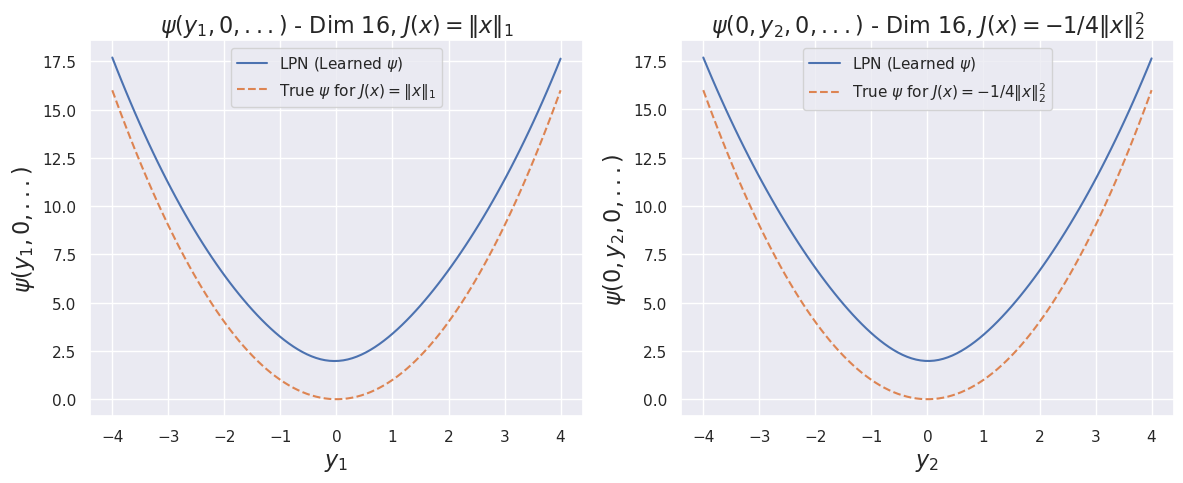

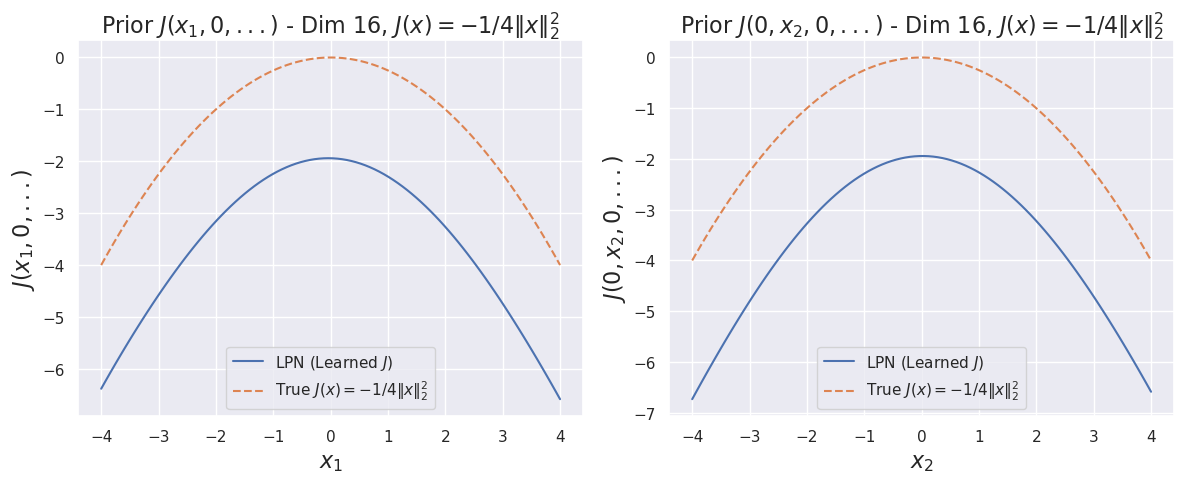

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.3250,  3.4492, -8.0240,  ...,  5.9074, -7.4347,  2.7111],
        [-1.1427,  0.5715, -5.7826,  ...,  5.8820, -6.3257, -1.2974],
        [ 7.3155,  0.6989,  3.1151,  ..., -0.9881,  6.5456, -3.1984],
        ...,
        [-4.3187, -0.5045,  3.9286,  ...,  7.4977, -6.8024, -4.6433],
        [ 3.1220, -1.1959,  5.5372,  ..., -7.8260, -2.5124,  2.9020],
        [ 6.2697, -2.3324, -1.1484,  ..., -6.8374,  3.1477, -0.9637]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 7434.27099609375
iteration 0 loss 183.9416046142578


iteration 500 loss 56.91297912597656


iteration 1000 loss 17.623029708862305


iteration 1500 loss 1.926547646522522


iteration 2000 loss 1.6243268251419067


iteration 2500 loss 1.1229991912841797


iteration 3000 loss 0.8797858953475952


iteration 3500 loss 0.7061171531677246


iteration 4000 loss 0.7094507217407227


iteration 4500 loss 0.5821250081062317


iteration 5000 loss 0.5002300143241882


iteration 5500 loss 0.5725436210632324


iteration 6000 loss 0.46399611234664917


iteration 6500 loss 0.4058057367801666


iteration 7000 loss 0.4710089862346649


iteration 7500 loss 0.35825470089912415


iteration 8000 loss 0.3177986741065979


iteration 8500 loss 0.3282524645328522


iteration 9000 loss 0.2869366705417633


iteration 9500 loss 0.3014773428440094


iteration 10000 loss 0.24721196293830872


iteration 10500 loss 0.2373436540365219


iteration 11000 loss 0.31731370091438293


iteration 11500 loss 0.2326856404542923


iteration 12000 loss 0.20890571177005768


iteration 12500 loss 0.2694641649723053


iteration 13000 loss 0.1968618929386139


iteration 13500 loss 0.1793345957994461


iteration 14000 loss 0.18344414234161377


iteration 14500 loss 0.1652373969554901


iteration 15000 loss 0.17096300423145294


iteration 15500 loss 0.1530502736568451


iteration 16000 loss 0.15274111926555634


iteration 16500 loss 0.13933584094047546


iteration 17000 loss 0.13720081746578217


iteration 17500 loss 0.14155225455760956


iteration 18000 loss 0.12657280266284943


iteration 18500 loss 0.13082656264305115


iteration 19000 loss 0.11902637034654617


iteration 19500 loss 0.12695948779582977


iteration 20000 loss 0.11316396296024323


iteration 20500 loss 0.11725608259439468


iteration 21000 loss 0.10458921641111374


iteration 21500 loss 0.10444051027297974


iteration 22000 loss 41.68749237060547


iteration 22500 loss 0.10098426789045334


iteration 23000 loss 0.09361502528190613


iteration 23500 loss 0.09403406083583832


iteration 24000 loss 1.4110897779464722


iteration 24500 loss 0.0876394510269165


iteration 25000 loss 0.09649009257555008


iteration 25500 loss 0.08313339203596115


iteration 26000 loss 0.08240369707345963


iteration 26500 loss 0.11341597884893417


iteration 27000 loss 0.07604500651359558


iteration 27500 loss 0.07620874047279358


iteration 28000 loss 0.0793762356042862


iteration 28500 loss 0.07021098583936691


iteration 29000 loss 0.06953991204500198


iteration 29500 loss 0.0688953623175621


iteration 30000 loss 0.07115013152360916


iteration 30500 loss 0.09233561903238297


iteration 31000 loss 0.06776981055736542


iteration 31500 loss 0.06175411865115166


iteration 32000 loss 0.061504144221544266


iteration 32500 loss 0.06176357343792915


iteration 33000 loss 0.06047884002327919


iteration 33500 loss 0.061597589403390884


iteration 34000 loss 18.401554107666016


iteration 34500 loss 0.05553627759218216


iteration 35000 loss 0.05378452315926552


iteration 35500 loss 0.053672756999731064


iteration 36000 loss 0.055881500244140625


iteration 36500 loss 0.05437536910176277


iteration 37000 loss 0.05912279710173607


iteration 37500 loss 0.06621973216533661


iteration 38000 loss 0.04961250349879265


iteration 38500 loss 0.049118202179670334


iteration 39000 loss 0.048908162862062454


iteration 39500 loss 0.047194693237543106


iteration 40000 loss 0.045853447169065475


iteration 40500 loss 0.04668845981359482


iteration 41000 loss 0.044048797339200974


iteration 41500 loss 0.04345446452498436


iteration 42000 loss 0.04397080838680267


iteration 42500 loss 0.04317345842719078


iteration 43000 loss 0.175837442278862


iteration 43500 loss 0.05430777370929718


iteration 44000 loss 0.040829818695783615


iteration 44500 loss 0.04042358323931694


iteration 45000 loss 0.0404285192489624


iteration 45500 loss 0.22316250205039978


iteration 46000 loss 0.038890838623046875


iteration 46500 loss 0.03881875425577164


iteration 47000 loss 0.040295183658599854


iteration 47500 loss 0.03755492717027664


iteration 48000 loss 0.036510784178972244


iteration 48500 loss 0.036329980939626694


iteration 49000 loss 0.035379160195589066


iteration 49500 loss 0.03563689440488815


iteration 50000 loss 0.035386450588703156


iteration 50500 loss 0.03452376276254654


iteration 51000 loss 0.04641119763255119


iteration 51500 loss 0.033925723284482956


iteration 52000 loss 3.1335291862487793


iteration 52500 loss 0.03307643160223961


iteration 53000 loss 0.033668067306280136


iteration 53500 loss 0.03266631066799164


iteration 54000 loss 0.03273028880357742


iteration 54500 loss 0.03293374180793762


iteration 55000 loss 0.03155360743403435


iteration 55500 loss 0.03097822330892086


iteration 56000 loss 0.03186272457242012


iteration 56500 loss 0.030415566638112068


iteration 57000 loss 0.02994628995656967


iteration 57500 loss 0.030034037306904793


iteration 58000 loss 0.02962455525994301


iteration 58500 loss 0.0290236659348011


iteration 59000 loss 0.028773104771971703


iteration 59500 loss 0.02908356301486492


iteration 60000 loss 0.0516078919172287


iteration 60500 loss 0.16632230579853058


iteration 61000 loss 0.08074658364057541


iteration 61500 loss 0.03134647011756897


iteration 62000 loss 0.027224084362387657


iteration 62500 loss 0.02829250693321228


iteration 63000 loss 0.027767736464738846


iteration 63500 loss 2.717275619506836


iteration 64000 loss 0.02678241766989231


iteration 64500 loss 0.08985431492328644


iteration 65000 loss 0.046529240906238556


iteration 65500 loss 0.045730020850896835


iteration 66000 loss 0.09223233908414841


iteration 66500 loss 0.02581431157886982


iteration 67000 loss 0.026189640164375305


iteration 67500 loss 0.025531157851219177


iteration 68000 loss 1.7406492233276367


iteration 68500 loss 0.025234127417206764


iteration 69000 loss 0.02901473082602024


iteration 69500 loss 0.025289330631494522


iteration 70000 loss 0.02722868323326111


iteration 70500 loss 0.02419985644519329


iteration 71000 loss 0.024385331198573112


iteration 71500 loss 0.02401023358106613


iteration 72000 loss 0.0240298043936491


iteration 72500 loss 0.02584821917116642


iteration 73000 loss 0.028771288692951202


iteration 73500 loss 0.02378040738403797


iteration 74000 loss 0.025917716324329376


iteration 74500 loss 0.02304571121931076


iteration 75000 loss 0.02398279868066311


iteration 75500 loss 0.0231611467897892


iteration 76000 loss 0.06903641670942307


iteration 76500 loss 0.9353805184364319


iteration 77000 loss 0.022702574729919434


iteration 77500 loss 0.0244014672935009


iteration 78000 loss 0.03997856378555298


iteration 78500 loss 0.022376684471964836


iteration 79000 loss 0.022823987528681755


iteration 79500 loss 0.021906808018684387


iteration 80000 loss 0.02286454103887081


iteration 80500 loss 0.2793656587600708


iteration 81000 loss 0.021914636716246605


iteration 81500 loss 0.022443994879722595


iteration 82000 loss 0.021501492708921432


iteration 82500 loss 0.021349430084228516


iteration 83000 loss 0.02133929170668125


iteration 83500 loss 0.051552288234233856


iteration 84000 loss 0.02091175876557827


iteration 84500 loss 0.02110256813466549


iteration 85000 loss 0.021114541217684746


iteration 85500 loss 0.020677506923675537


iteration 86000 loss 0.07167798280715942


iteration 86500 loss 0.02170075662434101


iteration 87000 loss 0.020416276529431343


iteration 87500 loss 0.02587614767253399


iteration 88000 loss 0.19327206909656525


iteration 88500 loss 0.20883701741695404


iteration 89000 loss 0.0718088373541832


iteration 89500 loss 0.023269405588507652


iteration 90000 loss 0.4377612769603729


iteration 90500 loss 0.3087201714515686


iteration 91000 loss 0.07478126883506775


iteration 91500 loss 0.13045042753219604


iteration 92000 loss 0.02729385904967785


iteration 92500 loss 0.05152790620923042


iteration 93000 loss 0.0233061071485281


iteration 93500 loss 0.11426280438899994


iteration 94000 loss 0.019320383667945862


iteration 94500 loss 0.03116997890174389


iteration 95000 loss 0.6661682724952698


iteration 95500 loss 0.05912981182336807


iteration 96000 loss 0.08484137803316116


iteration 96500 loss 0.02167341113090515


iteration 97000 loss 0.03853560984134674


iteration 97500 loss 0.02698272280395031


iteration 98000 loss 0.019045192748308182


iteration 98500 loss 0.019260527566075325


iteration 99000 loss 0.15643799304962158


iteration 99500 loss 0.03270893171429634


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.2657706141471863


iteration 100500 loss 0.01801133155822754


iteration 101000 loss 0.01778310537338257


iteration 101500 loss 0.017567668110132217


iteration 102000 loss 0.017354734241962433


iteration 102500 loss 0.01713934727013111


iteration 103000 loss 0.016919627785682678


iteration 103500 loss 0.016694342717528343


iteration 104000 loss 0.016461951658129692


iteration 104500 loss 0.0162203311920166


iteration 105000 loss 0.04367044195532799


iteration 105500 loss 0.016809016466140747


iteration 106000 loss 0.01562603935599327


iteration 106500 loss 0.015482892282307148


iteration 107000 loss 0.015358618460595608


iteration 107500 loss 0.015211299993097782


iteration 108000 loss 0.015088400803506374


iteration 108500 loss 0.014974190853536129


iteration 109000 loss 0.014863171614706516


iteration 109500 loss 0.014758322387933731


iteration 110000 loss 0.014694205485284328


iteration 110500 loss 0.014561234973371029


iteration 111000 loss 0.014467470347881317


iteration 111500 loss 0.014546175487339497


iteration 112000 loss 0.014282108284533024


iteration 112500 loss 0.014197615906596184


iteration 113000 loss 0.014217442832887173


iteration 113500 loss 0.01402710098773241


iteration 114000 loss 0.013954446651041508


iteration 114500 loss 0.013884094543755054


iteration 115000 loss 0.013796132989227772


iteration 115500 loss 0.0137169836089015


iteration 116000 loss 0.013645907863974571


iteration 116500 loss 0.01358142402023077


iteration 117000 loss 0.013498863205313683


iteration 117500 loss 0.013439142145216465


iteration 118000 loss 0.013362704776227474


iteration 118500 loss 0.01329202763736248


iteration 119000 loss 0.013228775933384895


iteration 119500 loss 0.013412054628133774


iteration 120000 loss 0.014892106875777245


iteration 120500 loss 0.013035024516284466


iteration 121000 loss 0.01297097746282816


iteration 121500 loss 0.012906237505376339


iteration 122000 loss 0.012848805636167526


iteration 122500 loss 0.01278847735375166


iteration 123000 loss 0.012727429158985615


iteration 123500 loss 0.01267264038324356


iteration 124000 loss 0.012614904902875423


iteration 124500 loss 0.012557324022054672


iteration 125000 loss 0.01249895989894867


iteration 125500 loss 0.012444778345525265


iteration 126000 loss 0.012788084335625172


iteration 126500 loss 0.015364279970526695


iteration 127000 loss 0.012277113273739815


iteration 127500 loss 0.012221149168908596


iteration 128000 loss 0.03447454050183296


iteration 128500 loss 0.012218327261507511


iteration 129000 loss 0.012240545824170113


iteration 129500 loss 0.01201503537595272


iteration 130000 loss 0.011963773518800735


iteration 130500 loss 0.011911590583622456


iteration 131000 loss 0.0461394228041172


iteration 131500 loss 0.09048136323690414


iteration 132000 loss 0.01176205649971962


iteration 132500 loss 0.011713909916579723


iteration 133000 loss 0.011663686484098434


iteration 133500 loss 0.011619465425610542


iteration 134000 loss 0.011570930480957031


iteration 134500 loss 0.017821179702878


iteration 135000 loss 0.011479238979518414


iteration 135500 loss 0.01143625658005476


iteration 136000 loss 0.011387589387595654


iteration 136500 loss 0.011346157640218735


iteration 137000 loss 0.011301699094474316


iteration 137500 loss 0.011255855672061443


iteration 138000 loss 0.011264974251389503


iteration 138500 loss 0.011170363053679466


iteration 139000 loss 0.01112774945795536


iteration 139500 loss 0.011083642020821571


iteration 140000 loss 0.01104507502168417


iteration 140500 loss 0.011000744998455048


iteration 141000 loss 0.010959227569401264


iteration 141500 loss 0.010918749496340752


iteration 142000 loss 0.010876993648707867


iteration 142500 loss 0.017163308337330818


iteration 143000 loss 0.023219071328639984


iteration 143500 loss 0.010921511799097061


iteration 144000 loss 0.010716750286519527


iteration 144500 loss 0.026648323982954025


iteration 145000 loss 0.01063635852187872


iteration 145500 loss 0.010601217858493328


iteration 146000 loss 0.010558618232607841


iteration 146500 loss 0.010663372464478016


iteration 147000 loss 0.012462404556572437


iteration 147500 loss 0.010445728898048401


iteration 148000 loss 0.010409707203507423


iteration 148500 loss 0.010458795353770256


iteration 149000 loss 0.010335358791053295


iteration 149500 loss 0.010303011164069176


iteration 150000 loss 0.011534513905644417


iteration 150500 loss 0.010232159867882729


iteration 151000 loss 0.010863594710826874


iteration 151500 loss 0.01016452256590128


iteration 152000 loss 0.010952742770314217


iteration 152500 loss 0.010094483382999897


iteration 153000 loss 0.01005950104445219


iteration 153500 loss 0.010023551993072033


iteration 154000 loss 0.009991425089538097


iteration 154500 loss 0.009959530085325241


iteration 155000 loss 0.009927159175276756


iteration 155500 loss 0.009935461916029453


iteration 156000 loss 0.010249689221382141


iteration 156500 loss 0.00982730183750391


iteration 157000 loss 0.00979362428188324


iteration 157500 loss 0.00976264663040638


iteration 158000 loss 0.011101643554866314


iteration 158500 loss 0.009697791188955307


iteration 159000 loss 0.009668825194239616


iteration 159500 loss 0.009647727943956852


iteration 160000 loss 0.009605102241039276


iteration 160500 loss 0.009573278948664665


iteration 161000 loss 0.00954409223049879


iteration 161500 loss 0.009515739046037197


iteration 162000 loss 0.009626058861613274


iteration 162500 loss 0.009458227083086967


iteration 163000 loss 0.00946520734578371


iteration 163500 loss 0.009397890418767929


iteration 164000 loss 0.009365694597363472


iteration 164500 loss 0.009340460412204266


iteration 165000 loss 0.009310133755207062


iteration 165500 loss 0.012681514956057072


iteration 166000 loss 0.009252521209418774


iteration 166500 loss 0.009225460700690746


iteration 167000 loss 0.009195145219564438


iteration 167500 loss 0.009170623496174812


iteration 168000 loss 0.01082463189959526


iteration 168500 loss 0.00911431759595871


iteration 169000 loss 0.009085630066692829


iteration 169500 loss 0.00911581702530384


iteration 170000 loss 0.012837512418627739


iteration 170500 loss 0.009006237611174583


iteration 171000 loss 0.008978315629065037


iteration 171500 loss 0.00895809754729271


iteration 172000 loss 0.008924691006541252


iteration 172500 loss 0.008898663334548473


iteration 173000 loss 0.008871776983141899


iteration 173500 loss 0.00884659681469202


iteration 174000 loss 0.008824662305414677


iteration 174500 loss 0.008894483558833599


iteration 175000 loss 0.008770949207246304


iteration 175500 loss 0.016766175627708435


iteration 176000 loss 0.010550722479820251


iteration 176500 loss 0.00869577843695879


iteration 177000 loss 0.008681279607117176


iteration 177500 loss 0.008646000176668167


iteration 178000 loss 0.008624652400612831


iteration 178500 loss 0.0085983294993639


iteration 179000 loss 0.008573956787586212


iteration 179500 loss 0.008550156839191914


iteration 180000 loss 0.008527085185050964


iteration 180500 loss 0.00850515253841877


iteration 181000 loss 0.008478955365717411


iteration 181500 loss 0.01094365119934082


iteration 182000 loss 0.00843137688934803


iteration 182500 loss 0.008841759525239468


iteration 183000 loss 0.00838659331202507


iteration 183500 loss 0.008363698609173298


iteration 184000 loss 0.008340069092810154


iteration 184500 loss 0.0385238379240036


iteration 185000 loss 0.008295007981359959


iteration 185500 loss 0.008318192325532436


iteration 186000 loss 0.00824990775436163


iteration 186500 loss 0.008229299448430538


iteration 187000 loss 0.008209976367652416


iteration 187500 loss 0.009847552515566349


iteration 188000 loss 0.00819067656993866


iteration 188500 loss 0.008142568171024323


iteration 189000 loss 0.008496602065861225


iteration 189500 loss 0.008099636994302273


iteration 190000 loss 0.009306009858846664


iteration 190500 loss 0.00805639661848545


iteration 191000 loss 0.040597207844257355


iteration 191500 loss 0.008014525286853313


iteration 192000 loss 0.007994065061211586


iteration 192500 loss 0.010582531802356243


iteration 193000 loss 0.007952277548611164


iteration 193500 loss 0.00793098658323288


iteration 194000 loss 0.007911394350230694


iteration 194500 loss 0.007931947708129883


iteration 195000 loss 0.007870150730013847


iteration 195500 loss 0.010874725878238678


iteration 196000 loss 0.00783061608672142


iteration 196500 loss 0.00780977588146925


iteration 197000 loss 0.007791975978761911


iteration 197500 loss 0.007771479431539774


iteration 198000 loss 0.00971934199333191


iteration 198500 loss 0.007735377177596092


iteration 199000 loss 0.007714391220360994


iteration 199500 loss 0.007696191314607859


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00767813203856349


iteration 200500 loss 0.0076752351596951485


iteration 201000 loss 0.0076721301302313805


iteration 201500 loss 0.007668479345738888


iteration 202000 loss 0.00766394566744566


iteration 202500 loss 0.00765818590298295


iteration 203000 loss 0.0076508368365466595


iteration 203500 loss 0.00764145702123642


iteration 204000 loss 0.007629441563040018


iteration 204500 loss 0.007614064496010542


iteration 205000 loss 0.0075945477001369


iteration 205500 loss 0.007577408105134964


iteration 206000 loss 0.007570350542664528


iteration 206500 loss 0.007541896775364876


iteration 207000 loss 0.007525937166064978


iteration 207500 loss 0.007507517468184233


iteration 208000 loss 0.007490354590117931


iteration 208500 loss 0.007473309524357319


iteration 209000 loss 0.007455054204910994


iteration 209500 loss 0.007438818458467722


iteration 210000 loss 0.007419295143336058


iteration 210500 loss 0.007405640557408333


iteration 211000 loss 0.007391492836177349


iteration 211500 loss 0.007420445792376995


iteration 212000 loss 0.007356134243309498


iteration 212500 loss 0.007338859140872955


iteration 213000 loss 0.007322295103222132


iteration 213500 loss 0.007306057959794998


iteration 214000 loss 0.0072874282486736774


iteration 214500 loss 0.007274422328919172


iteration 215000 loss 0.007259597070515156


iteration 215500 loss 0.007241234183311462


iteration 216000 loss 0.007224604487419128


iteration 216500 loss 0.007208042312413454


iteration 217000 loss 0.007194295525550842


iteration 217500 loss 0.00719478027895093


iteration 218000 loss 0.00716179795563221


iteration 218500 loss 0.007148371543735266


iteration 219000 loss 0.007137257605791092


iteration 219500 loss 0.007116597145795822


iteration 220000 loss 0.007102437783032656


iteration 220500 loss 0.007085554301738739


iteration 221000 loss 0.007075343281030655


iteration 221500 loss 0.007053565699607134


iteration 222000 loss 0.007040643598884344


iteration 222500 loss 0.007024217396974564


iteration 223000 loss 0.007009624503552914


iteration 223500 loss 0.006995979230850935


iteration 224000 loss 0.008010447956621647


iteration 224500 loss 0.006965565029531717


iteration 225000 loss 0.006951762363314629


iteration 225500 loss 0.007485414855182171


iteration 226000 loss 0.006922570057213306


iteration 226500 loss 0.00690938625484705


iteration 227000 loss 0.006892732810229063


iteration 227500 loss 0.006878863554447889


iteration 228000 loss 0.006885831709951162


iteration 228500 loss 0.006850296165794134


iteration 229000 loss 0.006836695596575737


iteration 229500 loss 0.006820855662226677


iteration 230000 loss 0.006808022037148476


iteration 230500 loss 0.006791775580495596


iteration 231000 loss 0.006779637653380632


iteration 231500 loss 0.006767519749701023


iteration 232000 loss 0.006751236971467733


iteration 232500 loss 0.006737494841217995


iteration 233000 loss 0.006722629070281982


iteration 233500 loss 0.0067226337268948555


iteration 234000 loss 0.007762233726680279


iteration 234500 loss 0.006682244129478931


iteration 235000 loss 0.006668983958661556


iteration 235500 loss 0.006653734482824802


iteration 236000 loss 0.006642652675509453


iteration 236500 loss 0.006629432085901499


iteration 237000 loss 0.006615349557250738


iteration 237500 loss 0.006602112203836441


iteration 238000 loss 0.006587532814592123


iteration 238500 loss 0.006576426327228546


iteration 239000 loss 0.006562292575836182


iteration 239500 loss 0.006548981182277203


iteration 240000 loss 0.006538141518831253


iteration 240500 loss 0.006524340249598026


iteration 241000 loss 0.006511674262583256


iteration 241500 loss 0.0064993384294211864


iteration 242000 loss 0.006485091056674719


iteration 242500 loss 0.006473776884377003


iteration 243000 loss 0.0064613306894898415


iteration 243500 loss 0.006447283551096916


iteration 244000 loss 0.006436105351895094


iteration 244500 loss 0.006428539287298918


iteration 245000 loss 0.006410450674593449


iteration 245500 loss 0.0064210775308310986


iteration 246000 loss 0.006385061424225569


iteration 246500 loss 0.006373491603881121


iteration 247000 loss 0.006359840743243694


iteration 247500 loss 0.006348289083689451


iteration 248000 loss 0.006337034981697798


iteration 248500 loss 0.006323940120637417


iteration 249000 loss 0.006312968209385872


iteration 249500 loss 0.006299965549260378


iteration 250000 loss 0.006288040429353714


iteration 250500 loss 0.011177526786923409


iteration 251000 loss 0.006264746189117432


iteration 251500 loss 0.006253794301301241


iteration 252000 loss 0.006239976268261671


iteration 252500 loss 0.006229927763342857


iteration 253000 loss 0.006218740250915289


iteration 253500 loss 0.006206016056239605


iteration 254000 loss 0.0061935982666909695


iteration 254500 loss 0.006180291995406151


iteration 255000 loss 0.006171675398945808


iteration 255500 loss 0.006161064840853214


iteration 256000 loss 0.006148368585854769


iteration 256500 loss 0.006136839743703604


iteration 257000 loss 0.006124324165284634


iteration 257500 loss 0.006114841438829899


iteration 258000 loss 0.006102822255343199


iteration 258500 loss 0.006091903895139694


iteration 259000 loss 0.006079969462007284


iteration 259500 loss 0.006068069487810135


iteration 260000 loss 0.006059060804545879


iteration 260500 loss 0.006047992035746574


iteration 261000 loss 0.006036166101694107


iteration 261500 loss 0.0060264007188379765


iteration 262000 loss 0.006014604587107897


iteration 262500 loss 0.006003931630402803


iteration 263000 loss 0.005995320621877909


iteration 263500 loss 0.006004096008837223


iteration 264000 loss 0.005973097402602434


iteration 264500 loss 0.005964004434645176


iteration 265000 loss 0.005950983613729477


iteration 265500 loss 0.005940447561442852


iteration 266000 loss 0.005928634665906429


iteration 266500 loss 0.0059195151552557945


iteration 267000 loss 0.005907924380153418


iteration 267500 loss 0.005898104049265385


iteration 268000 loss 0.005888735875487328


iteration 268500 loss 0.005876501090824604


iteration 269000 loss 0.005867821164429188


iteration 269500 loss 0.0058576264418661594


iteration 270000 loss 0.005846777465194464


iteration 270500 loss 0.005842549726366997


iteration 271000 loss 0.005825111176818609


iteration 271500 loss 0.005817157682031393


iteration 272000 loss 0.005807267967611551


iteration 272500 loss 0.005795816890895367


iteration 273000 loss 0.005787483882158995


iteration 273500 loss 0.0057780565693974495


iteration 274000 loss 0.005767075810581446


iteration 274500 loss 0.005757243372499943


iteration 275000 loss 0.005746757611632347


iteration 275500 loss 0.00574202835559845


iteration 276000 loss 0.005725350230932236


iteration 276500 loss 0.005718353670090437


iteration 277000 loss 0.005709995981305838


iteration 277500 loss 0.005698834080249071


iteration 278000 loss 0.005688904784619808


iteration 278500 loss 0.0056788926012814045


iteration 279000 loss 0.005668852012604475


iteration 279500 loss 0.005658009089529514


iteration 280000 loss 0.005650092847645283


iteration 280500 loss 0.005640053190290928


iteration 281000 loss 0.005630332510918379


iteration 281500 loss 0.005621626973152161


iteration 282000 loss 0.005610238760709763


iteration 282500 loss 0.005602446850389242


iteration 283000 loss 0.0055943639017641544


iteration 283500 loss 0.005582856480032206


iteration 284000 loss 0.0055745686404407024


iteration 284500 loss 0.005580136086791754


iteration 285000 loss 0.005554748699069023


iteration 285500 loss 0.00554790161550045


iteration 286000 loss 0.00553973950445652


iteration 286500 loss 0.005529140587896109


iteration 287000 loss 0.0055207484401762486


iteration 287500 loss 0.005510119721293449


iteration 288000 loss 0.005502492189407349


iteration 288500 loss 0.005493846256285906


iteration 289000 loss 0.005483751185238361


iteration 289500 loss 0.005475716665387154


iteration 290000 loss 0.00546580133959651


iteration 290500 loss 0.005457596853375435


iteration 291000 loss 0.005451621487736702


iteration 291500 loss 0.005439791828393936


iteration 292000 loss 0.005429447162896395


iteration 292500 loss 0.005421254318207502


iteration 293000 loss 0.005414489656686783


iteration 293500 loss 0.005406409967690706


iteration 294000 loss 0.0053961924277246


iteration 294500 loss 0.005388793535530567


iteration 295000 loss 0.0053794486448168755


iteration 295500 loss 0.005371082574129105


iteration 296000 loss 0.005363386124372482


iteration 296500 loss 0.005354636814445257


iteration 297000 loss 0.0053458064794540405


iteration 297500 loss 0.005339466035366058


iteration 298000 loss 0.005328353960067034


iteration 298500 loss 0.005330070853233337


iteration 299000 loss 0.005310821812599897


iteration 299500 loss 0.005303069017827511


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.005293199326843023


iteration 300500 loss 0.005291948560625315


iteration 301000 loss 0.005290352273732424


iteration 301500 loss 0.005288273096084595


iteration 302000 loss 0.005285622552037239


iteration 302500 loss 0.0052822427824139595


iteration 303000 loss 0.005277905613183975


iteration 303500 loss 0.005272347014397383


iteration 304000 loss 0.005265264771878719


iteration 304500 loss 0.005256231874227524


iteration 305000 loss 0.005244855303317308


iteration 305500 loss 0.005237637087702751


iteration 306000 loss 0.0052304258570075035


iteration 306500 loss 0.005221305415034294


iteration 307000 loss 0.005210153292864561


iteration 307500 loss 0.005202684085816145


iteration 308000 loss 0.0051937163807451725


iteration 308500 loss 0.005182504653930664


iteration 309000 loss 0.005175281781703234


iteration 309500 loss 0.005166906863451004


iteration 310000 loss 0.005156331229954958


iteration 310500 loss 0.005148025695234537


iteration 311000 loss 0.005139780696481466


iteration 311500 loss 0.005129536613821983


iteration 312000 loss 0.005120971705764532


iteration 312500 loss 0.005113525316119194


iteration 313000 loss 0.005104122683405876


iteration 313500 loss 0.005093523766845465


iteration 314000 loss 0.005086359567940235


iteration 314500 loss 0.005077319219708443


iteration 315000 loss 0.005066629499197006


iteration 315500 loss 0.005059749819338322


iteration 316000 loss 0.005051027983427048


iteration 316500 loss 0.005040195304900408


iteration 317000 loss 0.0050340513698756695


iteration 317500 loss 0.005026598460972309


iteration 318000 loss 0.005017261486500502


iteration 318500 loss 0.005008128937333822


iteration 319000 loss 0.005001496989279985


iteration 319500 loss 0.004993109032511711


iteration 320000 loss 0.004982636775821447


iteration 320500 loss 0.004975710064172745


iteration 321000 loss 0.004967289976775646


iteration 321500 loss 0.004958687350153923


iteration 322000 loss 0.004950413014739752


iteration 322500 loss 0.004942348226904869


iteration 323000 loss 0.004932065960019827


iteration 323500 loss 0.004925562534481287


iteration 324000 loss 0.004918299615383148


iteration 324500 loss 0.0049091484397649765


iteration 325000 loss 0.004900732077658176


iteration 325500 loss 0.004893490578979254


iteration 326000 loss 0.0048842900432646275


iteration 326500 loss 0.0048757740296423435


iteration 327000 loss 0.004868786782026291


iteration 327500 loss 0.004859947599470615


iteration 328000 loss 0.004851507488638163


iteration 328500 loss 0.0048455726355314255


iteration 329000 loss 0.004838079679757357


iteration 329500 loss 0.004828595090657473


iteration 330000 loss 0.00482128607109189


iteration 330500 loss 0.004813925363123417


iteration 331000 loss 0.004804687574505806


iteration 331500 loss 0.004797575995326042


iteration 332000 loss 0.0047912378795444965


iteration 332500 loss 0.004783181007951498


iteration 333000 loss 0.004773670341819525


iteration 333500 loss 0.004768522921949625


iteration 334000 loss 0.004762099124491215


iteration 334500 loss 0.004753950051963329


iteration 335000 loss 0.004745039623230696


iteration 335500 loss 0.004739624913781881


iteration 336000 loss 0.004732748493552208


iteration 336500 loss 0.00472412770614028


iteration 337000 loss 0.004716608673334122


iteration 337500 loss 0.004710797220468521


iteration 338000 loss 0.004703444428741932


iteration 338500 loss 0.004694286733865738


iteration 339000 loss 0.004687836859375238


iteration 339500 loss 0.004680783022195101


iteration 340000 loss 0.0046719820238649845


iteration 340500 loss 0.004665151238441467


iteration 341000 loss 0.004659181926399469


iteration 341500 loss 0.004651640076190233


iteration 342000 loss 0.004649586044251919


iteration 342500 loss 0.004637709818780422


iteration 343000 loss 0.004631842952221632


iteration 343500 loss 0.004624431487172842


iteration 344000 loss 0.0046152761206030846


iteration 344500 loss 0.004610020201653242


iteration 345000 loss 0.004603674169629812


iteration 345500 loss 0.004595749080181122


iteration 346000 loss 0.004588089883327484


iteration 346500 loss 0.004582902882248163


iteration 347000 loss 0.004576319362968206


iteration 347500 loss 0.004568039905279875


iteration 348000 loss 0.004561328794807196


iteration 348500 loss 0.004555517341941595


iteration 349000 loss 0.004548155702650547


iteration 349500 loss 0.004539597313851118


iteration 350000 loss 0.004534754902124405


iteration 350500 loss 0.0045286365784704685


iteration 351000 loss 0.0045209056697785854


iteration 351500 loss 0.0045137167908251286


iteration 352000 loss 0.004508506506681442


iteration 352500 loss 0.004501906223595142


iteration 353000 loss 0.004493705928325653


iteration 353500 loss 0.00448724115267396


iteration 354000 loss 0.004481406882405281


iteration 354500 loss 0.00447382777929306


iteration 355000 loss 0.00446625892072916


iteration 355500 loss 0.004461492877453566


iteration 356000 loss 0.00445545744150877


iteration 356500 loss 0.004447781480848789


iteration 357000 loss 0.004440834280103445


iteration 357500 loss 0.004434955306351185


iteration 358000 loss 0.004427499137818813


iteration 358500 loss 0.004420334007591009


iteration 359000 loss 0.004414987284690142


iteration 359500 loss 0.004408240783959627


iteration 360000 loss 0.004446197766810656


iteration 360500 loss 0.0043951719999313354


iteration 361000 loss 0.004389327019453049


iteration 361500 loss 0.00438197236508131


iteration 362000 loss 0.004375028423964977


iteration 362500 loss 0.004369494505226612


iteration 363000 loss 0.0043624816462397575


iteration 363500 loss 0.004354946315288544


iteration 364000 loss 0.004350731614977121


iteration 364500 loss 0.004345364402979612


iteration 365000 loss 0.004338609054684639


iteration 365500 loss 0.004330858588218689


iteration 366000 loss 0.004325891379266977


iteration 366500 loss 0.004319603554904461


iteration 367000 loss 0.004311719443649054


iteration 367500 loss 0.0043068500235676765


iteration 368000 loss 0.004301522392779589


iteration 368500 loss 0.0042947749607264996


iteration 369000 loss 0.004287340212613344


iteration 369500 loss 0.004282401409000158


iteration 370000 loss 0.004276183433830738


iteration 370500 loss 0.004268390592187643


iteration 371000 loss 0.004263743292540312


iteration 371500 loss 0.00425909087061882


iteration 372000 loss 0.004253196995705366


iteration 372500 loss 0.004245810676366091


iteration 373000 loss 0.004240607842803001


iteration 373500 loss 0.004236217122524977


iteration 374000 loss 0.004230755381286144


iteration 374500 loss 0.004223675932735205


iteration 375000 loss 0.004217655397951603


iteration 375500 loss 0.004213325679302216


iteration 376000 loss 0.0042078434489667416


iteration 376500 loss 0.004200951661914587


iteration 377000 loss 0.0041947755962610245


iteration 377500 loss 0.004190669860690832


iteration 378000 loss 0.004185469355434179


iteration 378500 loss 0.004178878851234913


iteration 379000 loss 0.004172228742390871


iteration 379500 loss 0.004167769104242325


iteration 380000 loss 0.004162089433521032


iteration 380500 loss 0.004154946189373732


iteration 381000 loss 0.004149598069489002


iteration 381500 loss 0.00414435425773263


iteration 382000 loss 0.004137712065130472


iteration 382500 loss 0.004131224472075701


iteration 383000 loss 0.004126578103750944


iteration 383500 loss 0.004120664671063423


iteration 384000 loss 0.004114570561796427


iteration 384500 loss 0.004109128378331661


iteration 385000 loss 0.004103703424334526


iteration 385500 loss 0.004096833057701588


iteration 386000 loss 0.004091284703463316


iteration 386500 loss 0.004086975008249283


iteration 387000 loss 0.004081506747752428


iteration 387500 loss 0.004074643366038799


iteration 388000 loss 0.004069426096975803


iteration 388500 loss 0.004064567387104034


iteration 389000 loss 0.004058429505676031


iteration 389500 loss 0.004052046686410904


iteration 390000 loss 0.004048333503305912


iteration 390500 loss 0.004043582361191511


iteration 391000 loss 0.004037627950310707


iteration 391500 loss 0.004031030461192131


iteration 392000 loss 0.004027003422379494


iteration 392500 loss 0.004021889064460993


iteration 393000 loss 0.004015463404357433


iteration 393500 loss 0.004010414704680443


iteration 394000 loss 0.004005789291113615


iteration 394500 loss 0.003999941051006317


iteration 395000 loss 0.003993206657469273


iteration 395500 loss 0.0039892541244626045


iteration 396000 loss 0.003984243143349886


iteration 396500 loss 0.003977939952164888


iteration 397000 loss 0.003972738515585661


iteration 397500 loss 0.003968674689531326


iteration 398000 loss 0.003963535651564598


iteration 398500 loss 0.003957089968025684


iteration 399000 loss 0.003952166065573692


iteration 399500 loss 0.003947657998651266


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.003941958770155907


iteration 400500 loss 0.0039412337355315685


iteration 401000 loss 0.003940321505069733


iteration 401500 loss 0.003939167130738497


iteration 402000 loss 0.003937701229006052


iteration 402500 loss 0.003935900051146746


iteration 403000 loss 0.003933684900403023


iteration 403500 loss 0.003931018523871899


iteration 404000 loss 0.003927862737327814


iteration 404500 loss 0.003924187272787094


iteration 405000 loss 0.003920004703104496


iteration 405500 loss 0.003915437031537294


iteration 406000 loss 0.003910829778760672


iteration 406500 loss 0.0039062495343387127


iteration 407000 loss 0.0039016748778522015


iteration 407500 loss 0.0038971214089542627


iteration 408000 loss 0.0038925663102418184


iteration 408500 loss 0.003888040781021118


iteration 409000 loss 0.003883512457832694


iteration 409500 loss 0.0038790057878941298


iteration 410000 loss 0.003874513553455472


iteration 410500 loss 0.00387001340277493


iteration 411000 loss 0.0038655397947877645


iteration 411500 loss 0.003861064091324806


iteration 412000 loss 0.0038565974682569504


iteration 412500 loss 0.0038521531969308853


iteration 413000 loss 0.0038477126508951187


iteration 413500 loss 0.0038432790897786617


iteration 414000 loss 0.003838853444904089


iteration 414500 loss 0.003834446193650365


iteration 415000 loss 0.00383005291223526


iteration 415500 loss 0.0038256514817476273


iteration 416000 loss 0.0038212682120501995


iteration 416500 loss 0.003816891461610794


iteration 417000 loss 0.003812534036114812


iteration 417500 loss 0.0038081915117800236


iteration 418000 loss 0.003803839208558202


iteration 418500 loss 0.0037995020393282175


iteration 419000 loss 0.0037951802369207144


iteration 419500 loss 0.0037908677477389574


iteration 420000 loss 0.003786553628742695


iteration 420500 loss 0.003782260697335005


iteration 421000 loss 0.003777960315346718


iteration 421500 loss 0.0037736890371888876


iteration 422000 loss 0.003769423346966505


iteration 422500 loss 0.0037651476450264454


iteration 423000 loss 0.003760908031836152


iteration 423500 loss 0.0037566570099443197


iteration 424000 loss 0.0037524073850363493


iteration 424500 loss 0.003748183837160468


iteration 425000 loss 0.003743953537195921


iteration 425500 loss 0.0037397516425698996


iteration 426000 loss 0.0037355280946940184


iteration 426500 loss 0.0037313364446163177


iteration 427000 loss 0.003727136878296733


iteration 427500 loss 0.003722942667081952


iteration 428000 loss 0.003718756604939699


iteration 428500 loss 0.003714588936418295


iteration 429000 loss 0.003710426390171051


iteration 429500 loss 0.003706273389980197


iteration 430000 loss 0.0037021266762167215


iteration 430500 loss 0.0036979897413402796


iteration 431000 loss 0.0036938588600605726


iteration 431500 loss 0.0036897265817970037


iteration 432000 loss 0.003685615723952651


iteration 432500 loss 0.0036815067287534475


iteration 433000 loss 0.0036774089094251394


iteration 433500 loss 0.003673309925943613


iteration 434000 loss 0.0036692272406071424


iteration 434500 loss 0.003665148513391614


iteration 435000 loss 0.00366108026355505


iteration 435500 loss 0.0036570171359926462


iteration 436000 loss 0.003652954241260886


iteration 436500 loss 0.0036489050835371017


iteration 437000 loss 0.0036448705941438675


iteration 437500 loss 0.0036408391315490007


iteration 438000 loss 0.0036368188448250294


iteration 438500 loss 0.0036328125279396772


iteration 439000 loss 0.0036287945695221424


iteration 439500 loss 0.003624799894168973


iteration 440000 loss 0.0036208108067512512


iteration 440500 loss 0.003616831498220563


iteration 441000 loss 0.0036128507927060127


iteration 441500 loss 0.003608892671763897


iteration 442000 loss 0.0036049271002411842


iteration 442500 loss 0.0036009757313877344


iteration 443000 loss 0.0035970169119536877


iteration 443500 loss 0.0035930857993662357


iteration 444000 loss 0.0035891442093998194


iteration 444500 loss 0.003585214028134942


iteration 445000 loss 0.003581294324249029


iteration 445500 loss 0.0035773669369518757


iteration 446000 loss 0.0035734742414206266


iteration 446500 loss 0.0035695701371878386


iteration 447000 loss 0.0035656564868986607


iteration 447500 loss 0.0035617768298834562


iteration 448000 loss 0.0035579113755375147


iteration 448500 loss 0.0035540370736271143


iteration 449000 loss 0.0035501946695148945


iteration 449500 loss 0.0035463368985801935


iteration 450000 loss 0.003542480058968067


iteration 450500 loss 0.003538628574460745


iteration 451000 loss 0.0035347910597920418


iteration 451500 loss 0.0035309556405991316


iteration 452000 loss 0.003527136752381921


iteration 452500 loss 0.003523310413584113


iteration 453000 loss 0.0035194994416087866


iteration 453500 loss 0.0035157024394720793


iteration 454000 loss 0.0035119084641337395


iteration 454500 loss 0.0035081198439002037


iteration 455000 loss 0.0035043363459408283


iteration 455500 loss 0.0035005633253604174


iteration 456000 loss 0.003496797289699316


iteration 456500 loss 0.003493026364594698


iteration 457000 loss 0.003489276161417365


iteration 457500 loss 0.003485502442345023


iteration 458000 loss 0.00348177389241755


iteration 458500 loss 0.003478029742836952


iteration 459000 loss 0.003474289318546653


iteration 459500 loss 0.00347055378369987


iteration 460000 loss 0.0034668417647480965


iteration 460500 loss 0.003463126253336668


iteration 461000 loss 0.0034594314638525248


iteration 461500 loss 0.0034557338804006577


iteration 462000 loss 0.003452057484537363


iteration 462500 loss 0.003448358504101634


iteration 463000 loss 0.003444670233875513


iteration 463500 loss 0.003440981497988105


iteration 464000 loss 0.003437324659898877


iteration 464500 loss 0.0034336652606725693


iteration 465000 loss 0.0034300002735108137


iteration 465500 loss 0.0034263620618730783


iteration 466000 loss 0.003422720357775688


iteration 466500 loss 0.0034190737642347813


iteration 467000 loss 0.0034154511522501707


iteration 467500 loss 0.0034118215553462505


iteration 468000 loss 0.003408208256587386


iteration 468500 loss 0.003404596820473671


iteration 469000 loss 0.0034009995870292187


iteration 469500 loss 0.0033974056132137775


iteration 470000 loss 0.0033938151318579912


iteration 470500 loss 0.0033902181312441826


iteration 471000 loss 0.003386632539331913


iteration 471500 loss 0.003383059287443757


iteration 472000 loss 0.003379538655281067


iteration 472500 loss 0.0033759670332074165


iteration 473000 loss 0.0033723998349159956


iteration 473500 loss 0.0033688547555357218


iteration 474000 loss 0.0033653138671070337


iteration 474500 loss 0.003361764131113887


iteration 475000 loss 0.003358225803822279


iteration 475500 loss 0.00335469632409513


iteration 476000 loss 0.0033511617220938206


iteration 476500 loss 0.003347654826939106


iteration 477000 loss 0.003344143508002162


iteration 477500 loss 0.0033406384754925966


iteration 478000 loss 0.003337163245305419


iteration 478500 loss 0.003333665430545807


iteration 479000 loss 0.0033301927614957094


iteration 479500 loss 0.0033266921527683735


iteration 480000 loss 0.0033232092391699553


iteration 480500 loss 0.003319742623716593


iteration 481000 loss 0.00331627088598907


iteration 481500 loss 0.0033128061331808567


iteration 482000 loss 0.0033093485981225967


iteration 482500 loss 0.003305894322693348


iteration 483000 loss 0.0033024491276592016


iteration 483500 loss 0.0032990179024636745


iteration 484000 loss 0.0032955820206552744


iteration 484500 loss 0.0032921466045081615


iteration 485000 loss 0.0032887225970625877


iteration 485500 loss 0.00328530790284276


iteration 486000 loss 0.00328191090375185


iteration 486500 loss 0.0032784927170723677


iteration 487000 loss 0.0032750957179814577


iteration 487500 loss 0.0032717108260840178


iteration 488000 loss 0.0032683087047189474


iteration 488500 loss 0.0032649259082973003


iteration 489000 loss 0.0032615489326417446


iteration 489500 loss 0.003258177312090993


iteration 490000 loss 0.0032548061572015285


iteration 490500 loss 0.003251452697440982


iteration 491000 loss 0.003248092718422413


iteration 491500 loss 0.0032447671983391047


iteration 492000 loss 0.003241438651457429


iteration 492500 loss 0.003238094039261341


iteration 493000 loss 0.003234755713492632


iteration 493500 loss 0.0032314229756593704


iteration 494000 loss 0.0032281067688018084


iteration 494500 loss 0.0032247924245893955


iteration 495000 loss 0.0032214815728366375


iteration 495500 loss 0.0032181686256080866


iteration 496000 loss 0.0032148661557585


iteration 496500 loss 0.0032115804497152567


iteration 497000 loss 0.003208298236131668


iteration 497500 loss 0.003205009503290057


iteration 498000 loss 0.0032017247285693884


iteration 498500 loss 0.0031984751112759113


iteration 499000 loss 0.0031951989512890577


iteration 499500 loss 0.0031919353641569614


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


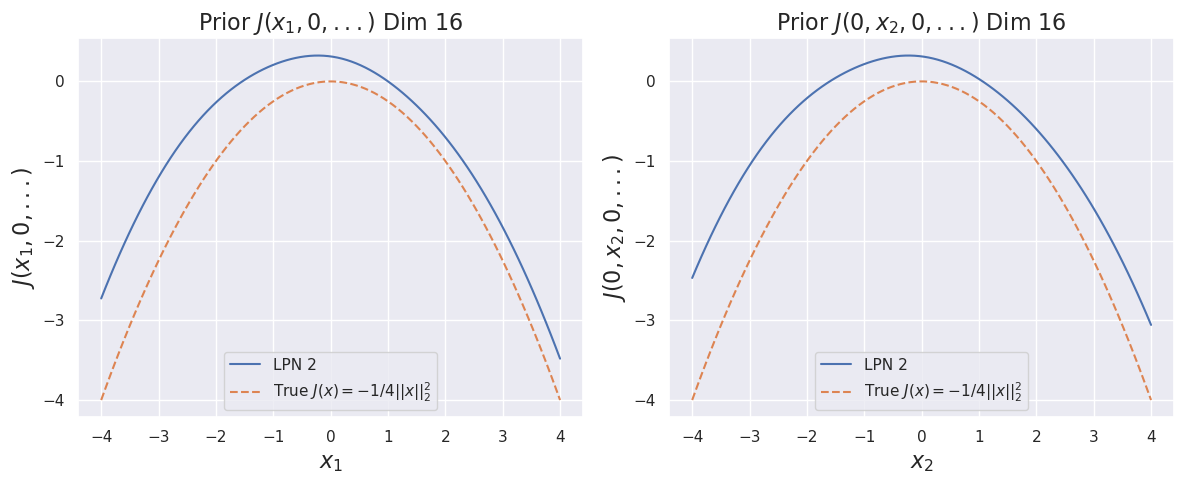

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)